In [70]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shdom



In [71]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

def projection_split(projections, n_parts):
    avg = len(projections.projection_list) / float(n_parts)
    out = []
    last = 0.0

    while last < len(projections.projection_list):
        out.append(shdom.MultiViewProjection(projections.projection_list[int(last):int(last + avg)]))
        last += avg

    return out

In [72]:
"""
Set settings
"""
#355, 380, 445, 470, 555, 660, 865, 935
wavelengths = [0.672]
vel_cloud = np.array([0.0,0.0,0.0]) # m/s
vel_camera = 45 # m/s
# A fly over from West to East (positive y-axis direction)
camera_zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
camera_azimuth_list = [-90, -90, -90, -90, 0, 90, 90, 90, 90]
num_of_viewed_medium = len(camera_zenith_list)
projection_type = 'perspective'
# input_cloud = 'rico52x57x26'
# input_cloud = 'rico32x37x26'
input_cloud = 'WIZ'

if len(wavelengths) > 1:
    type = 'polychromatic'
else:
    type = 'monochromatic'


output_dir = 'experiments/{}_vel_{}_img_{}_projection_{}/dynamic_medium_{}'.format(input_cloud, np.array_str(vel_cloud),
                                                                                   len(camera_zenith_list), projection_type,type)

# sun
sun_azimuth=65
sun_zenith=135

# solver
iter = 100

In [73]:
# Mie scattering for water droplets
mie_table_paths = [
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]

solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)
solar_fluxes = solar_fluxes / max(solar_fluxes)

In [74]:
# Load a Microphysical scatterer
droplets = shdom.MicrophysicalScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    camera_height = 3 #km
    droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/{}.txt'.format(input_cloud), veff=0.1)
else:
    camera_height = 4 #km
    assert np.any(vel_cloud==np.array([0.0,0.0,0.0]))
    data_dir = '../synthetic_cloud_fields/WIZ_Clouds/'
    format_ = 'BOMEX_1CLD_256x256x320_500CCNblowInv_10m_1sec_micro_256_*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    volumes_paths = volumes_paths[:num_of_viewed_medium]
    droplets.load_from_csv(volumes_paths[0])


In [75]:
com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])

L_list = (np.sign(camera_azimuth_list)) * (camera_height - com_z) * np.tan(np.deg2rad(camera_zenith_list) )

time_list = L_list *1e3 / vel_camera
time_list = np.mean(np.split(time_list,num_of_viewed_medium),1)
#sec
camera_position_list = np.zeros([L_list.shape[0],3])

# move the camera instead of the cloud
camera_position_list[:, 0] = com_x
camera_position_list[:, 1] = com_y + np.asarray(L_list)
camera_position_list[:, 2] = camera_height

In [76]:
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
air = shdom.MultispectralScatterer()

In [77]:
temporary_scatterer_list = []
grid = shdom.Grid(x=np.linspace(com_x-0.5,com_x+0.5,40),y=np.linspace(com_y-0.5,com_y+0.5,40),z=np.linspace(com_z-0.5,com_z+0.5,50))

for wavelength, table_path in zip(wavelengths, mie_table_paths):  
    # Molecular Rayleigh scattering
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.set_profile(temperature_profile.resample(air_grid))
    air.add_scatterer(rayleigh.get_scatterer())
    mie = shdom.MiePolydisperse()
    mie.read_table(table_path)
    if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
            droplets.add_mie(mie)
    else:
        for volumes_path, time in zip(volumes_paths, time_list):
            droplets = shdom.MicrophysicalScatterer()
            droplets.load_from_csv(volumes_path)
            droplets.add_mie(mie)
            droplets.resample(grid)
            lwc = droplets.lwc.data
            lwc /= 30 
            temporary_scatterer_list.append(shdom.TemporaryScatterer(droplets,time))
    


Reading mie table from file: ../mie_tables/polydisperse/Water_672nm.scat
Minimum medium effective radius [0.00] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.00] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.00] is smaller than the pre-computed table minimum r

In [78]:
dynamic_scatterer = shdom.DynamicScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    dynamic_scatterer.generate_dynamic_scatterer(scatterer=droplets, time_list=time_list, scatterer_velocity_list=vel_cloud)
else:
    dynamic_scatterer.add_temporary_scatterer(temporary_scatterer_list)

dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [79]:
scene_params_list = []
numerical_params_list =[]
for wavelength, solar_flux in zip(wavelengths, solar_fluxes):
    scene_params = shdom.SceneParameters(
        wavelength=wavelength,
        source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith, flux=solar_flux)
    )
    scene_params_list.append(scene_params)
    numerical_params = shdom.NumericalParameters(num_mu_bins=8,num_phi_bins=16)
    numerical_params_list.append(numerical_params)

In [80]:
dynamic_solver = shdom.DynamicRteSolver(scene_params=scene_params_list,numerical_params=numerical_params_list)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter)

In [81]:
projections = shdom.MultiViewProjection()

for camera_azimuth,camera_zenith,camera_position in zip(camera_azimuth_list,camera_zenith_list,camera_position_list):
     
    if projection_type == 'perspective':
         projection = (
                shdom.PerspectiveProjection(fov=30, 
                nx=200, ny=200, x=camera_position[0], y=camera_position[1],
                z=camera_position[2])
            )  
         projection.look_at_transform(point=com, up=[1.0, 0.0, 0.0])
         projections.add_projection(projection)
    else:
        projections.add_projection(
            shdom.OrthographicProjection(droplets.bounding_box,x_resolution=0.01,
                                         y_resolution=0.01,azimuth=camera_zenith,zenith=camera_zenith))

dynamic_projection = shdom.DynamicProjection(projection_split(projections, num_of_viewed_medium))

In [82]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), dynamic_projection)
images = dynamic_camera.render(dynamic_solver,n_jobs=40)

In [83]:
measurements = shdom.DynamicMeasurements(camera=dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)

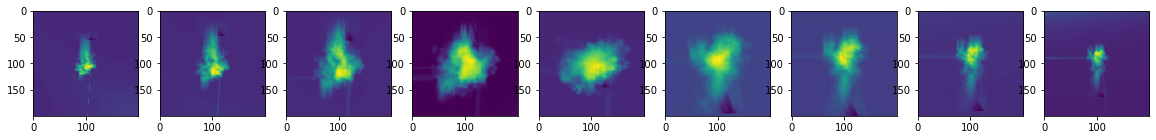

In [84]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, images):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    image -= image.min()
    ax.imshow(image/image.max())


In [85]:
shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)

In [86]:
a,b,c = shdom.load_dynamic_forward_model(output_dir)
print()